<a href="https://colab.research.google.com/github/biku1998/Damage_Vs_Normal_Vechile_Using_FastAI/blob/master/using_fastAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle Link : https://www.kaggle.com/anujms/car-damage-detection/kernels

### Let's try solving the problem using FastAi library

* FastAi contains all the arc that pytorch has, but in more fine tuned way, most of the hyper-parmeters are set to a good value that works for most computer vision task

* FastAi is built on top of pytorch.

* The documentation is great : https://docs.fast.ai/

In [0]:
# offload the data from drive to local instance for fast access
# change the below path if you have that zip file in different folder
!unzip '/content/drive/My Drive/scratch-detection/car-damage-detection.zip' -d ./data

Archive:  /content/drive/My Drive/scratch-detection/car-damage-detection.zip
  inflating: ./data/data1a/training/00-damage/0001.JPEG  
  inflating: ./data/data1a/training/00-damage/0002.JPEG  
  inflating: ./data/data1a/training/00-damage/0003.JPEG  
  inflating: ./data/data1a/training/00-damage/0004.JPEG  
  inflating: ./data/data1a/training/00-damage/0005.JPEG  
  inflating: ./data/data1a/training/00-damage/0006.JPEG  
  inflating: ./data/data1a/training/00-damage/0007.JPEG  
  inflating: ./data/data1a/training/00-damage/0008.JPEG  
  inflating: ./data/data1a/training/00-damage/0009.JPEG  
  inflating: ./data/data1a/training/00-damage/0010.JPEG  
  inflating: ./data/data1a/training/00-damage/0011.JPEG  
  inflating: ./data/data1a/training/00-damage/0012.JPEG  
  inflating: ./data/data1a/training/00-damage/0013.JPEG  
  inflating: ./data/data1a/training/00-damage/0014.JPEG  
  inflating: ./data/data1a/training/00-damage/0015.JPEG  
  inflating: ./data/data1a/training/00-damage/0016.JP

In [0]:
DATA_PATH = "/content/data/data1a/"

In [0]:
!nvidia-smi

Fri Mar 20 08:42:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    34W / 250W |   7045MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate,accuracy

In [0]:
batch_size = 64
data = ImageDataBunch.from_folder(DATA_PATH,train='training',valid='validation',ds_tfms= get_transforms(), size=224,bs = batch_size
                                  ).normalize(imagenet_stats)

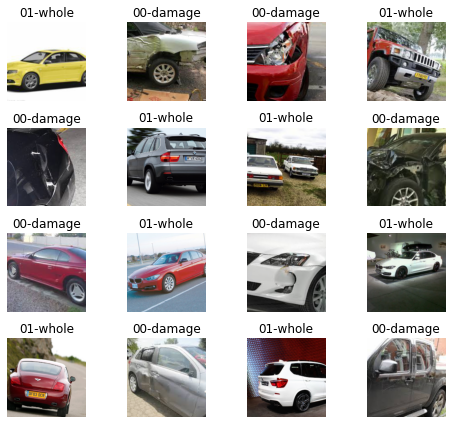

In [0]:
data.show_batch(rows=4, figsize=(7,6))

In [0]:
print(data.classes)
len(data.classes),data.c

['00-damage', '01-whole']


(2, 2)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy])

In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [0]:
learn.fit_one_cycle(9)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.578712,0.388833,0.100000,0.900000,00:33
1,0.475739,0.244793,0.093478,0.906522,00:33
2,0.377912,0.173032,0.067391,0.932609,00:34
3,0.294339,0.148858,0.065217,0.934783,00:33
4,0.234809,0.134366,0.050000,0.950000,00:33
5,0.201904,0.143915,0.054348,0.945652,00:34
6,0.171899,0.123421,0.041304,0.958696,00:33
7,0.145676,0.129954,0.045652,0.954348,00:34
8,0.131007,0.129515,0.045652,0.954348,00:33


* **FastAi calculates all the metrics on validation data , not training data**
* Let's save the model here , Since we have got a good accuracy
* The model will be saved in the same dir where the data is present

In [0]:
learn.save('stage-1')

In [0]:
# getting an model interpreter from the learn

interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

* It's basically saying show me top k images that my model has failed to classify properly

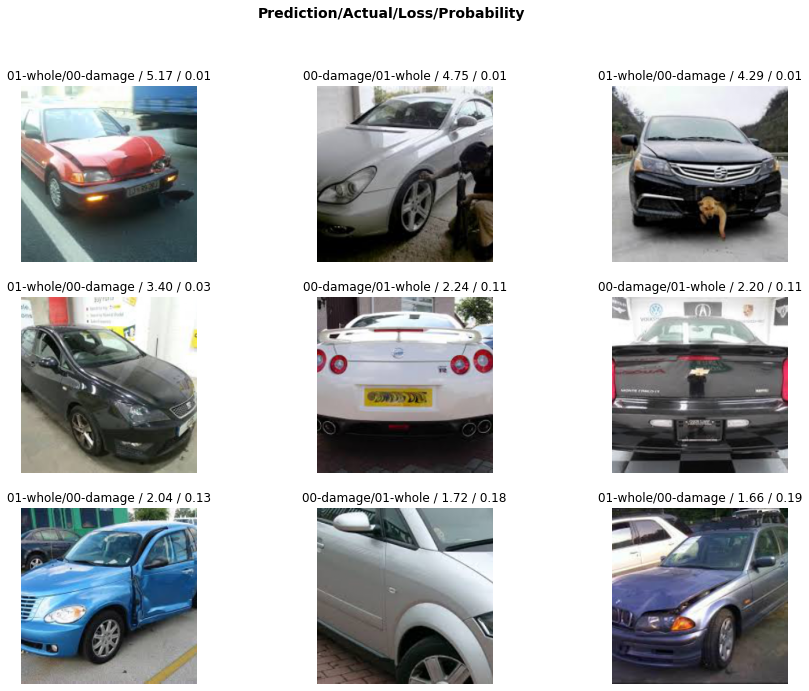

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

* If we look closely, some of the images are actually confusing to classify for humans also.

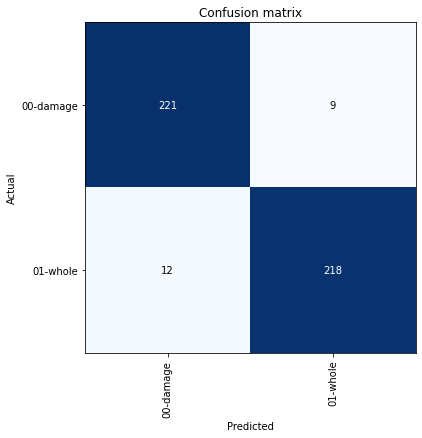

In [0]:
interp.plot_confusion_matrix(figsize=(6,6))

* Let's see if we can improve the model even more.
* FastAi has a fucn called learning rate finder i.e lr_find which will find the learning rate for which the error will not jump if we train futher

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


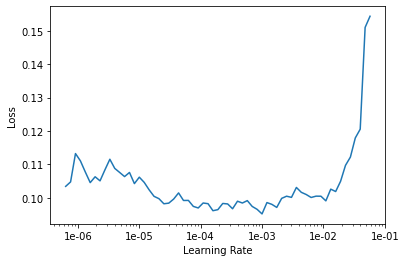

In [0]:
learn.recorder.plot()

* Looks like we can us learning rate between 1e-04 to 1e-03

In [0]:
learn.fit_one_cycle(1, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.090627,0.123518,0.041304,0.958696,00:33


In [0]:
learn.save('stage-2')

* Doing inference

In [0]:
learn.export() # this will create a .pkl file in the data folder itself, This file will be used in production env

In [0]:
defaults.device = torch.device('cpu') # we do inference on CPU instead if GPU. One of many reasons is because we have only 1 image, we will not take the benifit of batching

In [0]:
learn = load_learner(DATA_PATH) # load the .pkl file from the path

def inference_method(img):
    pred_class,pred_idx,outputs = learn.predict(img)
    return pred_class

01-whole


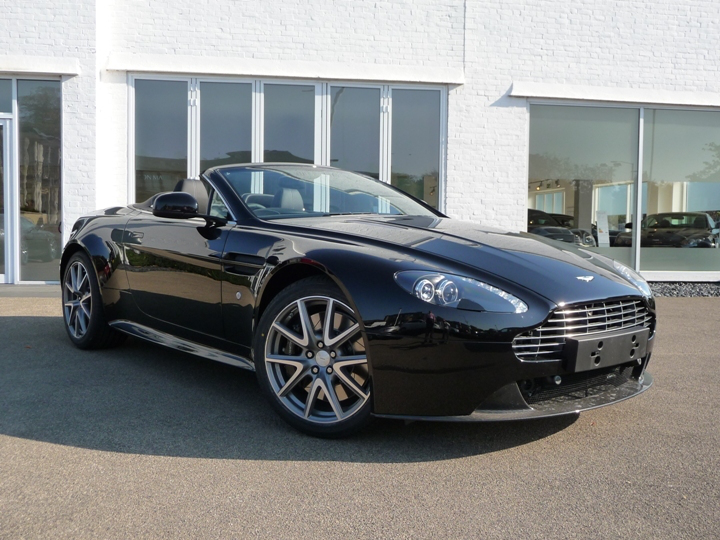

In [0]:
img = open_image('/content/data/data1a/validation/01-whole/0010.jpg') # load the image that you want to classify
print(inference_method(img));img

01-whole


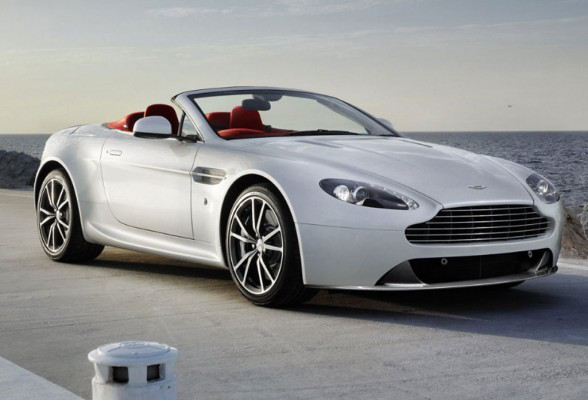

In [0]:
img = open_image('/content/data/data1a/validation/01-whole/0011.jpg') # load the image that you want to classify
print(inference_method(img));img

00-damage


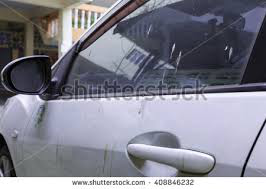

In [0]:
img = open_image('/content/data/data1a/validation/00-damage/0035.JPEG') # load the image that you want to classify
print(inference_method(img));img

00-damage


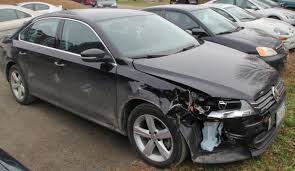

In [0]:
img = open_image('/content/data/data1a/validation/00-damage/0039.JPEG') # load the image that you want to classify
print(inference_method(img));img

00-damage


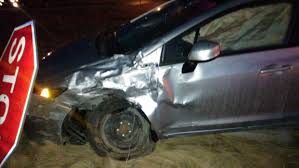

In [0]:
img = open_image('/content/data/data1a/validation/00-damage/0045.JPEG') # load the image that you want to classify
print(inference_method(img));img